In [ ]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# Initialize mlflow_tracking_uri variable
mlflow_tracking_uri = None  # Will be set in MLflow setup cell

In [ ]:
# Load dataset
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# MLflow setup for Databricks
import os

# Set up Databricks MLflow tracking
try:
    # Option 1: Use databricks:// URI (recommended)
    mlflow.set_tracking_uri("databricks")
    
    # Option 2: Alternative - use environment variable if set
    # databricks_host = os.getenv("DATABRICKS_HOST")
    # if databricks_host:
    #     mlflow.set_tracking_uri(f"databricks://{databricks_host}")
    
    # Create/set experiment
    experiment = mlflow.set_experiment("/Users/rajshakerp@gmail.com/HousePricePredictor")
    mlflow_tracking_uri = mlflow.get_tracking_uri()
    
    print(f"✅ MLflow tracking URI: {mlflow_tracking_uri}")
    print(f"✅ Experiment: {experiment.name}")
    print(f"✅ Experiment ID: {experiment.experiment_id}")
    
except Exception as e:
    print(f"⚠️ Databricks MLflow setup failed: {e}")
    print("📝 Please ensure you're authenticated with Databricks")
    print("💡 Run: databricks configure --token")
    print("   or set DATABRICKS_HOST and DATABRICKS_TOKEN environment variables")
    
    # Fallback to local for development
    print("🔄 Falling back to local MLflow for now...")
    mlflow_tracking_uri = 'file:./mlruns'
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    experiment = mlflow.set_experiment("House Price Prediction Experiment")
    print(f"📁 Using local tracking: {mlflow_tracking_uri}")

In [ ]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# Use XGBoost for RFE to stay consistent
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# RFE
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


In [ ]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


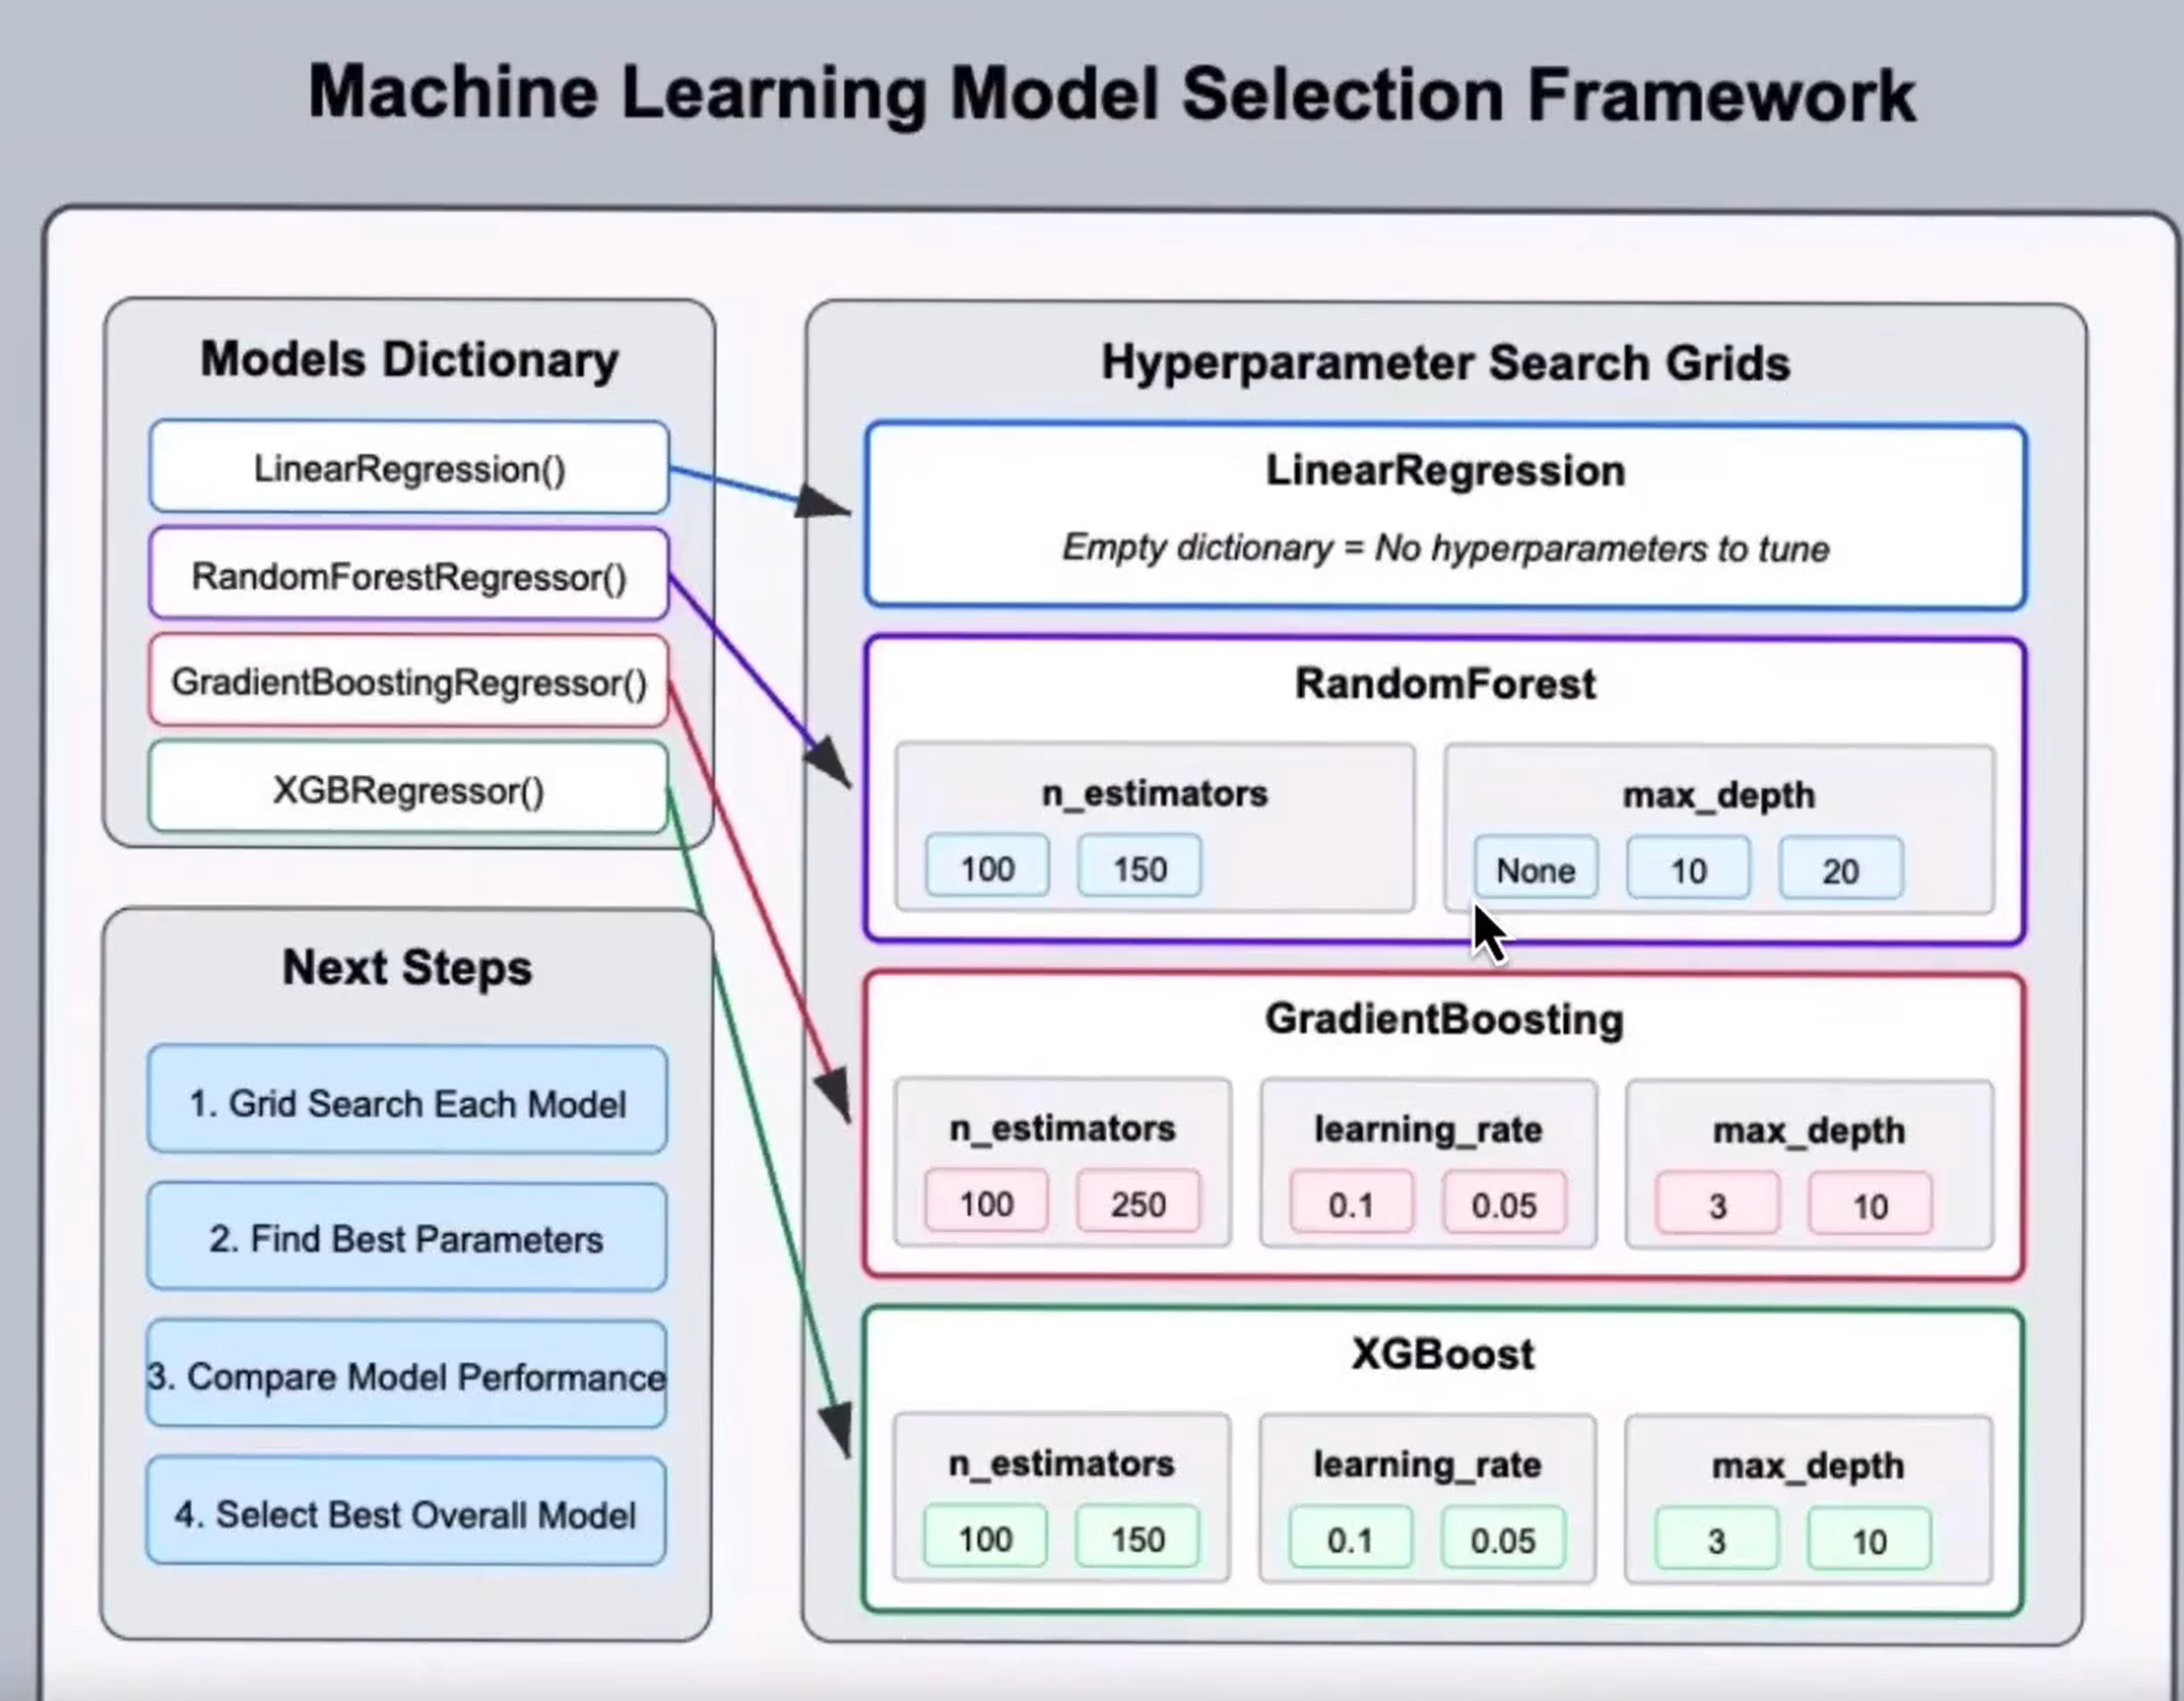

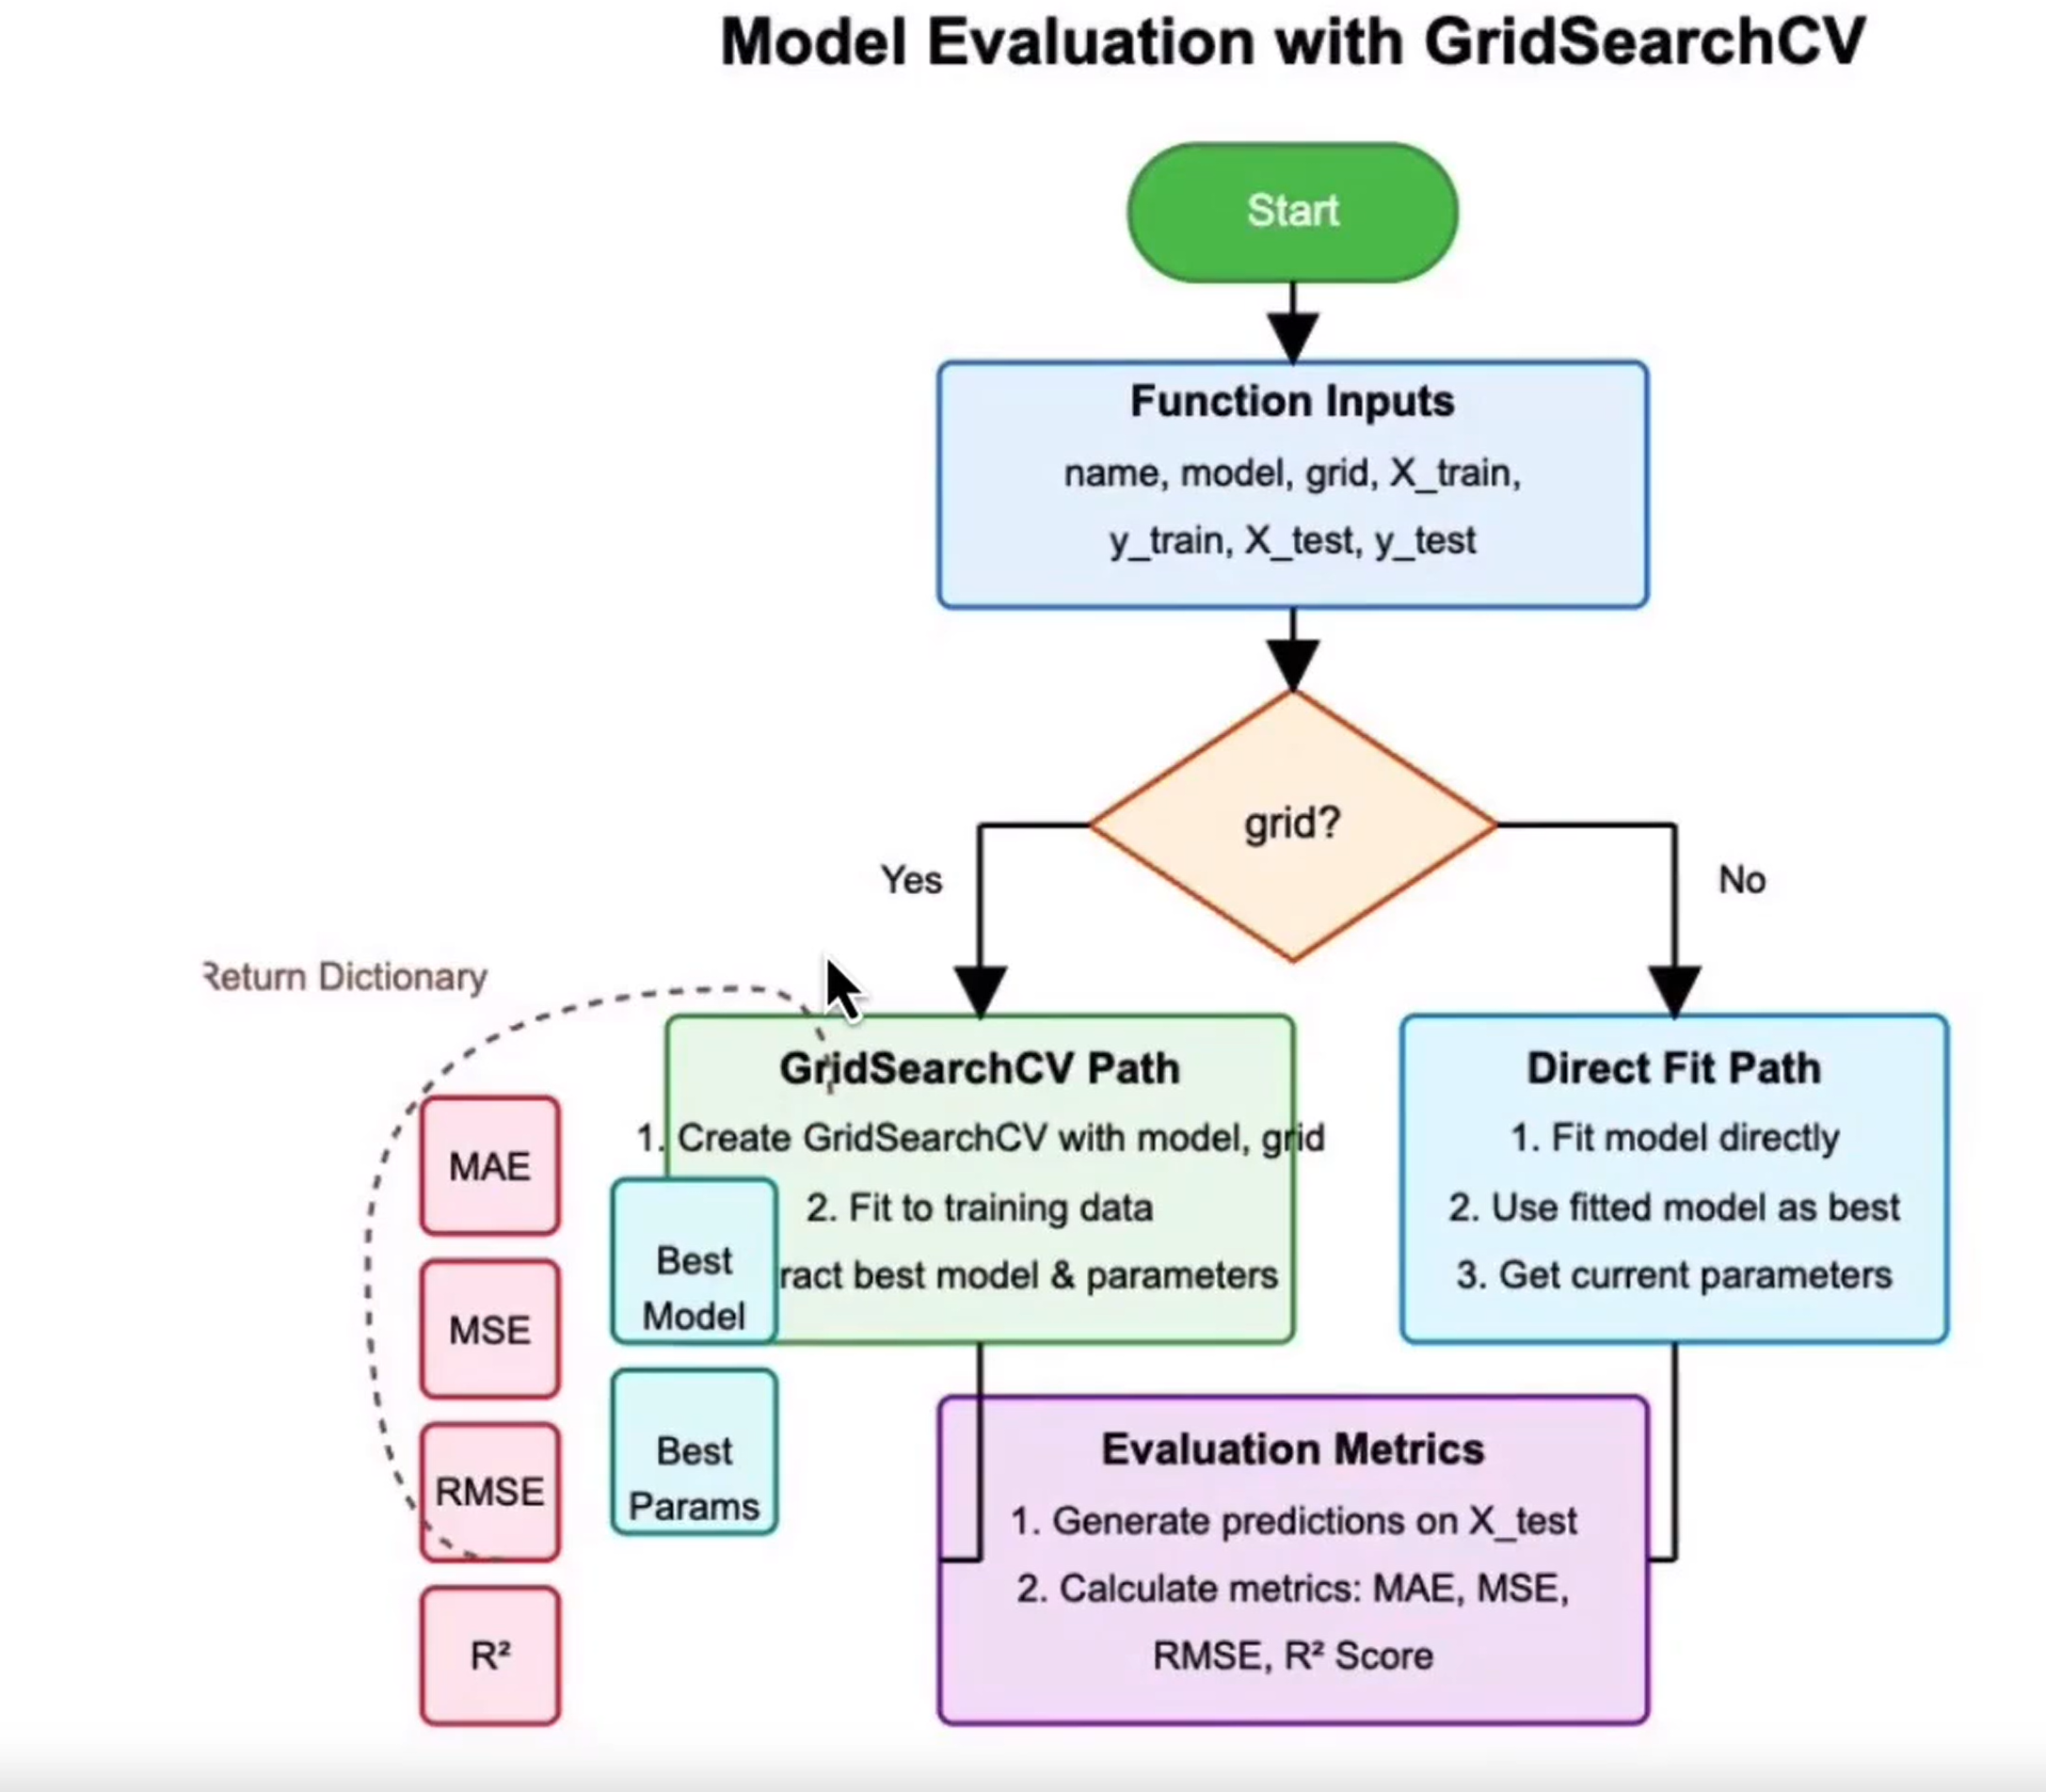

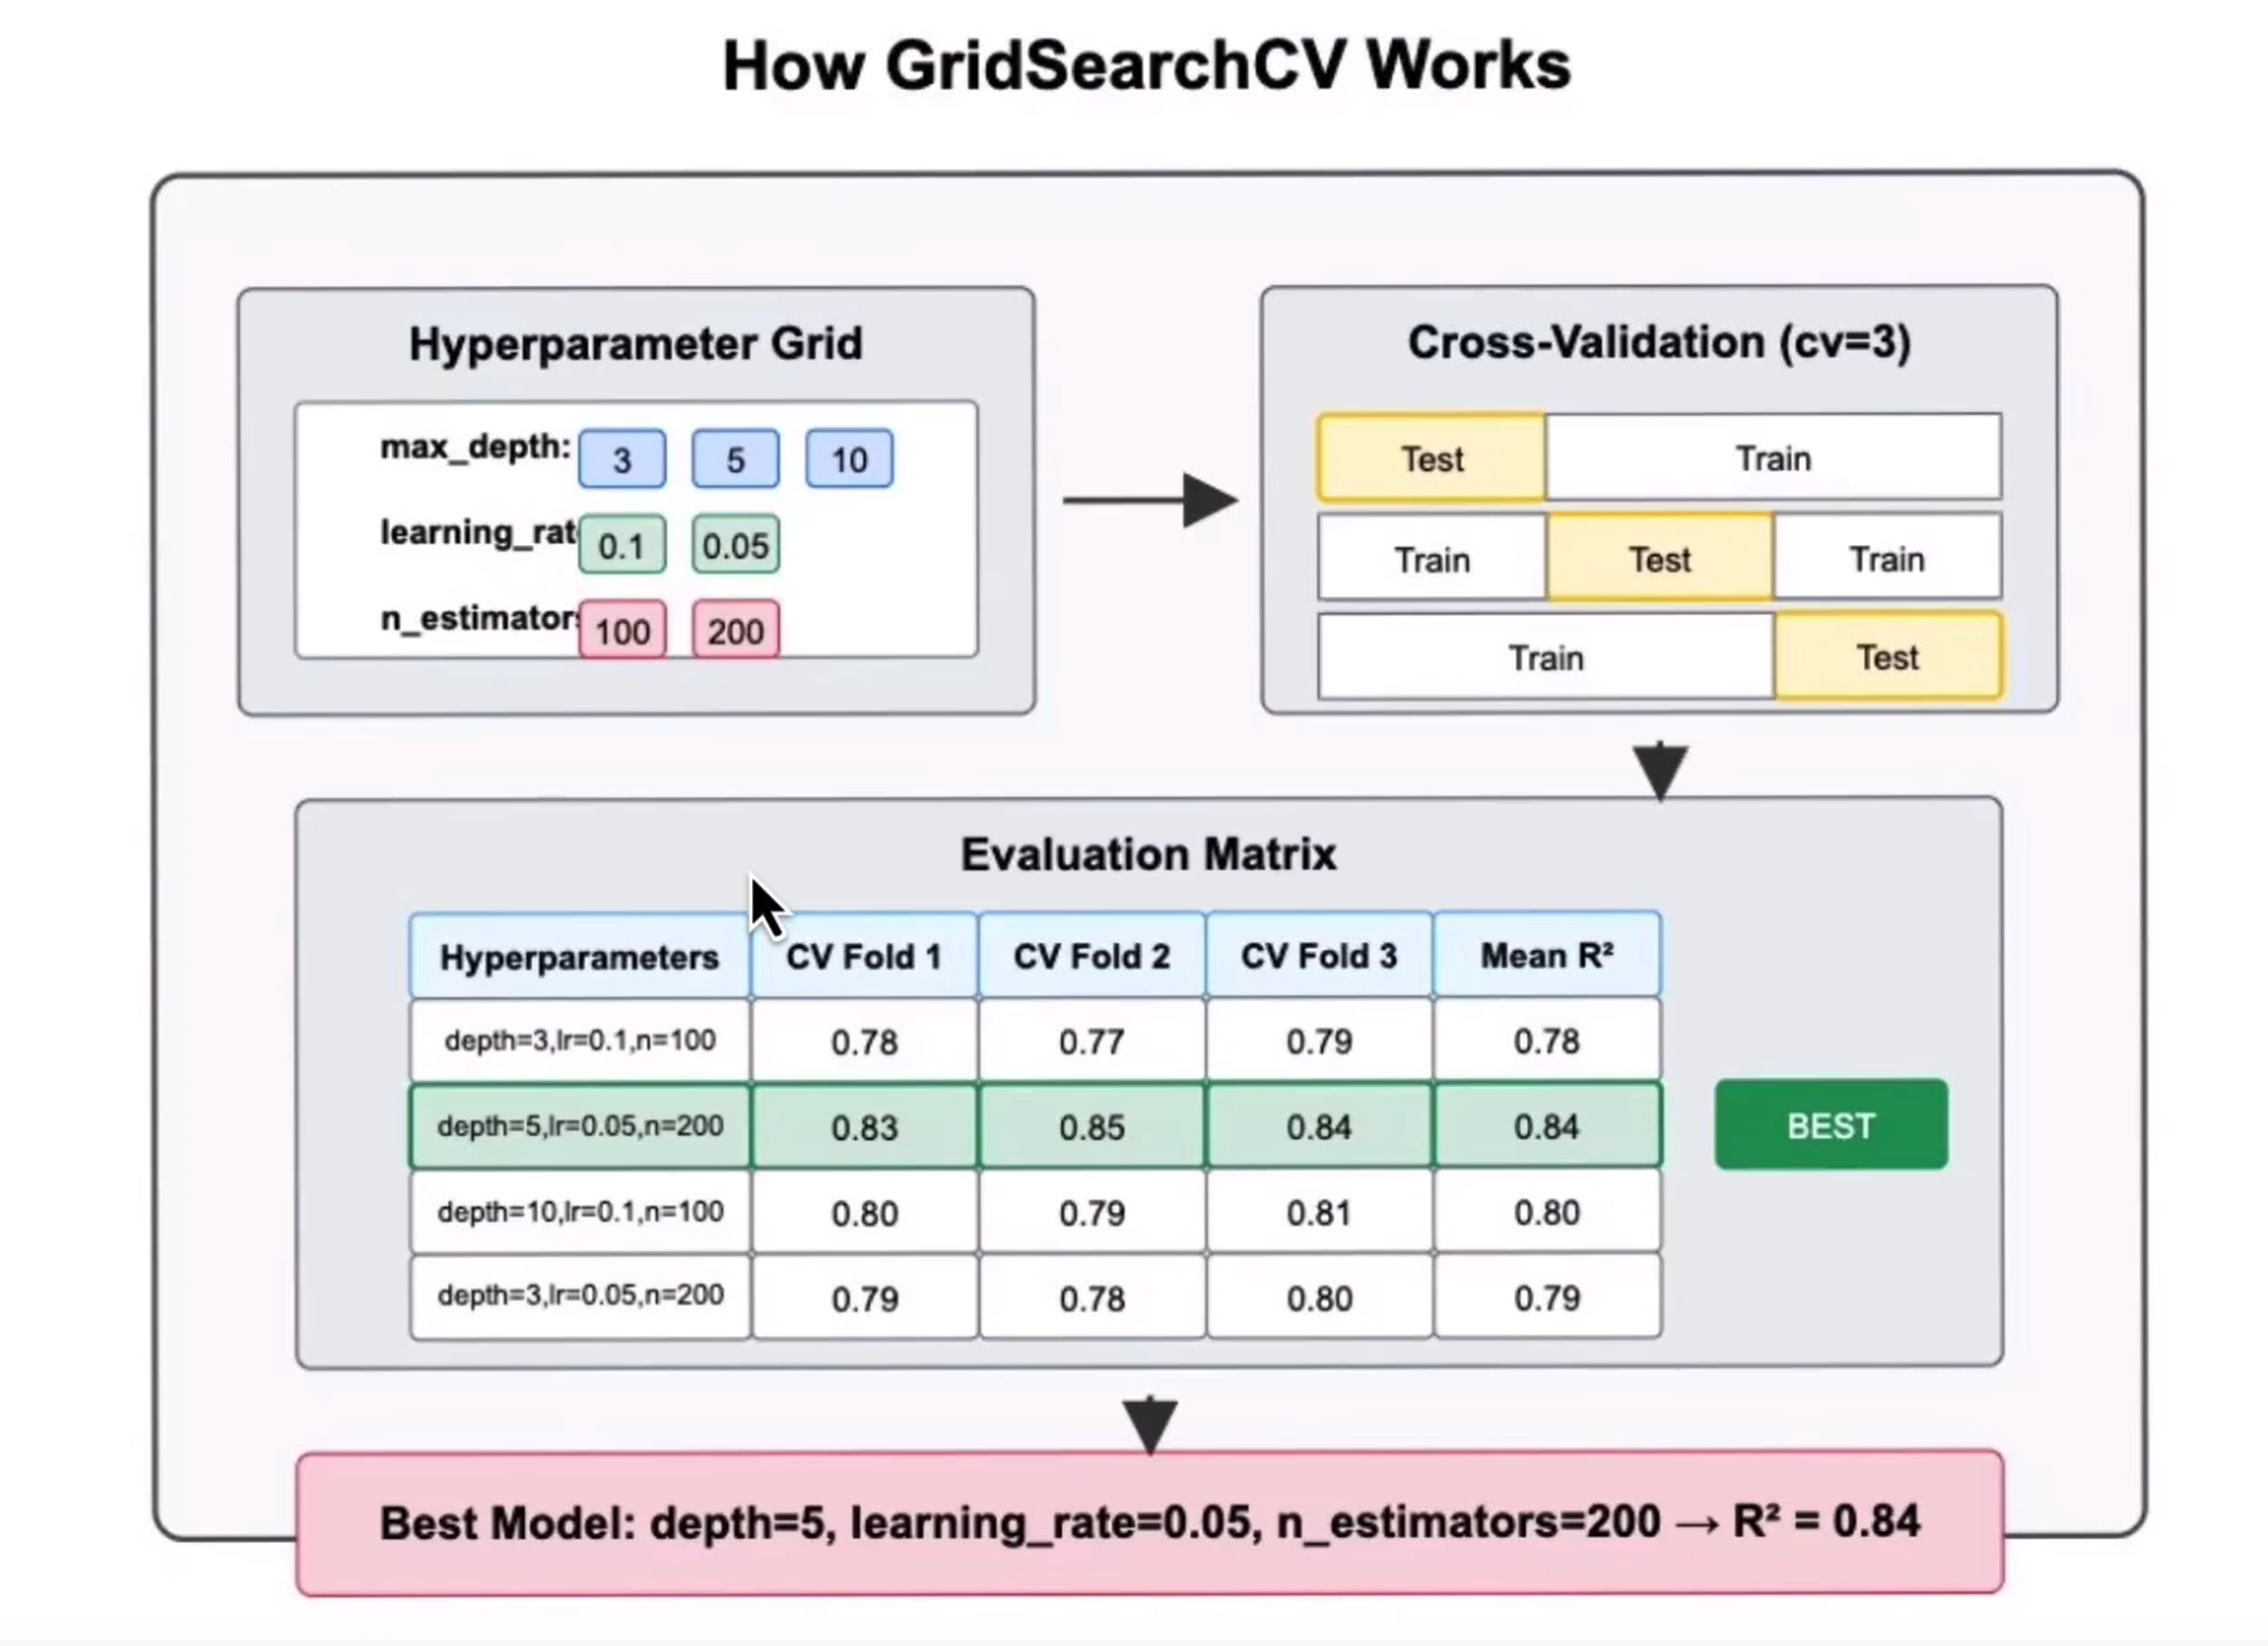

In [ ]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


In [ ]:
results = {}

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


In [ ]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [ ]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")


# Machine Learning Algorithms Comparison

## Overview of Algorithms Used

This notebook compares four different regression algorithms for house price prediction. Each algorithm has distinct characteristics, strengths, and use cases.

### 🔵 Linear Regression
**What it is:** A simple statistical method that finds the best-fitting straight line through data points.

**How it works:**
- Assumes a linear relationship: `price = β₀ + β₁×feature₁ + β₂×feature₂ + ...`
- Uses least squares to minimize prediction errors
- Very interpretable coefficients

**Strengths:**
- ✅ **Fast training and prediction**
- ✅ **Highly interpretable** - you can see exactly how each feature affects price
- ✅ **No hyperparameters to tune**
- ✅ **Works well with small datasets**
- ✅ **Low risk of overfitting**

**Weaknesses:**
- ❌ **Assumes linear relationships** - can't capture complex patterns
- ❌ **Sensitive to outliers**
- ❌ **Poor performance with non-linear data**

**When to use for house prices:**
- When you need to explain predictions to stakeholders
- When relationships are mostly linear (square footage → price)
- As a baseline model to compare others against

---

### 🟢 Random Forest
**What it is:** An ensemble of many decision trees that vote on the final prediction.

**How it works:**
- Creates hundreds of decision trees using random subsets of data and features
- Each tree makes a prediction, final result is the average
- Uses "bagging" (bootstrap aggregating) technique

**Strengths:**
- ✅ **Handles non-linear relationships naturally**
- ✅ **Robust to outliers**
- ✅ **Provides feature importance rankings**
- ✅ **Good performance out-of-the-box**
- ✅ **Handles mixed data types well**

**Weaknesses:**
- ❌ **Less interpretable than linear regression**
- ❌ **Can overfit with too many trees**
- ❌ **Memory intensive**
- ❌ **Biased toward categorical features with more levels**

**When to use for house prices:**
- When you have many features with complex interactions
- When data has outliers (luxury homes, unique properties)
- When you need feature importance insights
- For robust, general-purpose modeling

---

### 🟡 Gradient Boosting
**What it is:** Builds models sequentially, where each new model corrects errors from previous ones.

**How it works:**
- Starts with a simple prediction (often the mean)
- Builds subsequent models to predict the residual errors
- Combines all models with weighted votes
- Uses "boosting" technique

**Strengths:**
- ✅ **Often achieves highest accuracy**
- ✅ **Excellent for competitions**
- ✅ **Handles non-linear patterns very well**
- ✅ **Good with mixed data types**
- ✅ **Provides feature importance**

**Weaknesses:**
- ❌ **Prone to overfitting**
- ❌ **Requires careful hyperparameter tuning**
- ❌ **Sensitive to outliers**
- ❌ **Longer training time**
- ❌ **Less interpretable**

**When to use for house prices:**
- When accuracy is the primary goal
- When you have clean, preprocessed data
- When you have time for hyperparameter tuning
- For production systems where performance matters most

---

### 🔴 XGBoost (Extreme Gradient Boosting)
**What it is:** An optimized implementation of gradient boosting with additional features.

**How it works:**
- Similar to Gradient Boosting but with optimizations:
  - Regularization to prevent overfitting
  - Parallel processing for speed
  - Advanced tree pruning
  - Built-in cross-validation

**Strengths:**
- ✅ **State-of-the-art performance**
- ✅ **Built-in regularization**
- ✅ **Handles missing values automatically**
- ✅ **Very fast compared to other boosting methods**
- ✅ **Excellent feature importance**
- ✅ **Industry standard for tabular data**

**Weaknesses:**
- ❌ **Many hyperparameters to tune**
- ❌ **Can be complex to understand**
- ❌ **Still prone to overfitting without proper tuning**
- ❌ **Requires more computational resources**

**When to use for house prices:**
- When you want the best possible accuracy
- When you have sufficient data (hundreds+ samples)
- For production ML systems
- When dealing with complex feature interactions

---

## Decision Framework for House Price Prediction

### Choose **Linear Regression** when:
- You need to explain predictions to clients/stakeholders
- You have limited data (< 100 samples)
- Relationships appear mostly linear
- You need fast predictions
- Interpretability > Accuracy

### Choose **Random Forest** when:
- You want a good balance of performance and interpretability
- Your data has outliers or missing values
- You need feature importance rankings
- You want a robust, low-maintenance model
- You're starting with a new dataset

### Choose **Gradient Boosting** when:
- You have clean, well-preprocessed data
- Accuracy is more important than interpretability
- You have time for hyperparameter tuning
- You're building a competition model

### Choose **XGBoost** when:
- You want maximum accuracy
- You're building a production system
- You have computational resources for tuning
- You're working with tabular data
- You need to handle missing values automatically

---

## Real-World Example: When Each Shines

**Scenario 1: Real Estate Agent Tool**
- **Choose:** Linear Regression
- **Why:** Agents need to explain to clients why a house is priced a certain way

**Scenario 2: Automated Valuation Model (AVM)**
- **Choose:** XGBoost
- **Why:** Banks need highest accuracy for loan decisions, interpretability less critical

**Scenario 3: Market Analysis Dashboard**
- **Choose:** Random Forest
- **Why:** Good balance of accuracy and ability to show which factors drive prices

**Scenario 4: Research Study**
- **Choose:** Compare all four
- **Why:** Academic rigor requires understanding how different methods perform

In [ ]:
# Practical comparison of algorithm characteristics
print("🔍 ALGORITHM ANALYSIS SUMMARY")
print("=" * 50)

for name, result in results.items():
    model = result['model']
    print(f"\n📊 {name}:")
    print(f"   R² Score: {result['r2']:.4f}")
    print(f"   RMSE: ${result['rmse']:,.0f}")
    print(f"   MAE: ${result['mae']:,.0f}")
    
    # Show model-specific characteristics
    if name == 'LinearRegression':
        print(f"   📈 Linear coefficients available: {hasattr(model, 'coef_')}")
        print(f"   ⚡ Training time: Very Fast")
        print(f"   🧠 Interpretability: Highest")
        
    elif name == 'RandomForest':
        print(f"   🌳 Number of trees: {model.n_estimators}")
        print(f"   📊 Feature importance available: {hasattr(model, 'feature_importances_')}")
        print(f"   ⚡ Training time: Medium")
        print(f"   🧠 Interpretability: Medium")
        
    elif name == 'GradientBoosting':
        print(f"   🌳 Number of estimators: {model.n_estimators}")
        print(f"   📚 Learning rate: {model.learning_rate}")
        print(f"   ⚡ Training time: Slow")
        print(f"   🧠 Interpretability: Low")
        
    elif name == 'XGBoost':
        print(f"   🌳 Number of estimators: {model.n_estimators}")
        print(f"   📚 Learning rate: {model.learning_rate}")
        print(f"   🔧 Advanced optimizations: Yes")
        print(f"   ⚡ Training time: Medium-Fast")
        print(f"   🧠 Interpretability: Low")

print(f"\n🏆 WINNER: {best_model_name} with R² = {best_r2:.4f}")

# Performance vs Complexity trade-off
print(f"\n📈 PERFORMANCE vs COMPLEXITY ANALYSIS:")
print(f"Most Interpretable → Least Interpretable:")
sorted_by_interpretability = ['LinearRegression', 'RandomForest', 'GradientBoosting', 'XGBoost']
for model_name in sorted_by_interpretability:
    if model_name in results:
        r2 = results[model_name]['r2']
        print(f"   {model_name}: R² = {r2:.4f}")

In [ ]:
# Visualize Algorithm Characteristics
import matplotlib.pyplot as plt
import numpy as np

# Create a radar chart comparing algorithm characteristics
algorithms = ['Linear\nRegression', 'Random\nForest', 'Gradient\nBoosting', 'XGBoost']

# Define characteristics (1-5 scale)
characteristics = {
    'Accuracy': [2, 4, 5, 5],           # Based on typical performance
    'Interpretability': [5, 3, 2, 2],   # How easy to explain
    'Training Speed': [5, 3, 2, 4],     # How fast to train
    'Overfitting Risk': [1, 2, 4, 3],   # Lower is better (reversed for plotting)
    'Handles Non-linearity': [1, 4, 5, 5],  # How well it captures complex patterns
    'Memory Usage': [5, 2, 3, 3]        # Lower usage is better (reversed for plotting)
}

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Performance comparison
ax1.bar(algorithms, [results[model]['r2'] for model in ['LinearRegression', 'RandomForest', 'GradientBoosting', 'XGBoost']])
ax1.set_title('Model Performance (R² Score)', fontsize=14, fontweight='bold')
ax1.set_ylabel('R² Score')
ax1.grid(True, alpha=0.3)

# 2. Error comparison
rmse_values = [results[model]['rmse'] for model in ['LinearRegression', 'RandomForest', 'GradientBoosting', 'XGBoost']]
ax2.bar(algorithms, rmse_values, color='orange')
ax2.set_title('Prediction Error (RMSE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE ($)')
ax2.grid(True, alpha=0.3)

# 3. Characteristics comparison
x = np.arange(len(algorithms))
width = 0.15

for i, (char, values) in enumerate(characteristics.items()):
    ax3.bar(x + i*width, values, width, label=char)

ax3.set_title('Algorithm Characteristics Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score (1-5)')
ax3.set_xlabel('Algorithms')
ax3.set_xticks(x + width * 2)
ax3.set_xticklabels(algorithms)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Interpretability vs Performance trade-off
interpretability = [5, 3, 2, 2]  # Higher is more interpretable
performance = [results[model]['r2'] for model in ['LinearRegression', 'RandomForest', 'GradientBoosting', 'XGBoost']]

colors = ['blue', 'green', 'orange', 'red']
for i, (alg, interp, perf, color) in enumerate(zip(algorithms, interpretability, performance, colors)):
    ax4.scatter(interp, perf, s=200, c=color, alpha=0.7, label=alg)
    ax4.annotate(alg, (interp, perf), xytext=(5, 5), textcoords='offset points')

ax4.set_xlabel('Interpretability (Higher = More Interpretable)')
ax4.set_ylabel('Performance (R² Score)')
ax4.set_title('Interpretability vs Performance Trade-off', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# Summary insights
print("\n🎯 KEY INSIGHTS:")
print("=" * 40)
print("1. 📊 Linear Regression: Highest interpretability, lowest complexity")
print("2. 🌳 Random Forest: Good balance of performance and interpretability")
print("3. 🚀 Gradient Boosting: High performance but requires careful tuning")
print("4. ⚡ XGBoost: Often best performance with built-in optimizations")
print(f"\n💡 For house prices, consider {best_model_name} for best accuracy")
print("   But use Linear Regression if you need to explain predictions!")